























































































# 1 . Import Dependencies and Create folders project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz


In [ ]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
# Import uuid library to generate unique image names
import uuid

In [ ]:
# Import tensorflow dependecies -  Model class API
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer,Dense,Conv2D,MaxPooling2D,Input,Flatten,Dropout
from tensorflow.keras import metrics
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
import tensorflow as tf
# Avoid OOM erroes by settings GPu menorery
# Avoid OOM errors by setting GPU Memory Consumption Growth

In [ ]:
!unrar x "drive/MyDrive/data.rar"

In [ ]:
# Setup path
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANCHOR_PATH = os.path.join('data','anchor')

### 2 . Collect Positives and Anchors

## 2.1 Untar Labelled faces in te wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
for diretory in os.listdir('lfw'):
    for files in os.listdir(os.path.join('lfw',diretory)):
        EX_PATH = os.path.join('lfw',diretory,files)
        NEW_PATH = os.path.join(NEG_PATH,files)
        os.replace(EX_PATH,NEW_PATH)

# 3.Load and Preprocess image

## 3.1 Get image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'/*.jpg').take(10000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(10000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(10000)
print(len(anchor))
print(len(positive))
print(len(negative))

10000
10000
10000


## 3.2 Preprocessing - Scale and Resize

In [ ]:
def proprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

## 3.3 Create Labelled Dataset

In [ ]:
label_pos = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
label_neg = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
positives = tf.data.Dataset.zip((anchor,positive,label_pos))
negatives = tf.data.Dataset.zip((anchor,negative,label_neg))
data = positives.concatenate(negatives)
print(len(data))
samples = data.as_numpy_iterator().next()

20000


In [ ]:
samples

(b'data/anchor/96881cee-8e03-11ec-9f67-d05f6431b1ab.jpg',
 b'data/positive/a15b169f-8e05-11ec-b2da-d05f6431b1ab.jpg',
 1.0)

## 3.4 Buld Train and Test validation

b'data/anchor/96881cee-8e03-11ec-9f67-d05f6431b1ab.jpg' b'data/positive/a15b169f-8e05-11ec-b2da-d05f6431b1ab.jpg' 1.0
(100, 100, 3)
1.0


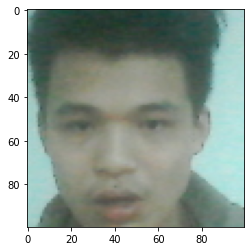

In [ ]:
def prepprocess_twin(input_img,validation_img,label):
    return(proprocess(input_img),proprocess(validation_img),label)
res = prepprocess_twin(*samples)
print(*samples)
plt.imshow(res[1])
print(res[1].shape)
print(res[2])

In [ ]:
# Builed dataloader pipeline
datas = data.map(prepprocess_twin).cache().shuffle(buffer_size=50000)
val_size = int(len(datas) * 0.1)
test_size = int(len(datas) * 0.1)
train_data = datas.skip(val_size+test_size)
train_data = train_data.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


valid_data = datas.take(val_size)
valid_data = valid_data.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_data = datas.take(test_size)
test_data = test_data.batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# 4.Model

## 4.1 Build Embedding layer

In [ ]:
class layer(tf.keras.layers.Layer):
    
    def __init__(self,units=None,activation=None):
        super(layer,self).__init__()
        
        self.units = units
        self.activation = activation
    def build(self,input_shape):
        
        init_weights = tf.keras.initializers.glorot_normal()
        w_val = init_weights(shape=(input_shape[-1],self.units),dtype='float32')
        self._weights_ = tf.Variable(w_val,trainable=True)
        
        init_bias = tf.keras.initializers.Zeros()
        b_val = init_bias(shape=(self.units),dtype='float32')
        self._bias_ = tf.Variable(b_val,trainable=True)
        
        super().build(input_shape)
    def call(self,x):
        
        x = tf.linalg.matmul(x,self._weights_)
        x = x+self._bias_
        return self.activation(x)

In [ ]:
class make_embeddings(tf.keras.layers.Layer):
    
    def __init__(self):
        super().__init__()
        
        self.c1 = Conv2D(filters=64,kernel_size=(10,10),activation='relu')
        self.m1 = MaxPooling2D(pool_size=(2,2),padding='same')
        self.c2 = Conv2D(filters=128,kernel_size=(7,7),activation='relu')
        self.m2 = MaxPooling2D(pool_size=(2,2),padding='same')
        self.c3 = Conv2D(filters=128,kernel_size=(4,4),activation='relu')
        self.m3 = MaxPooling2D(pool_size=(2,2),padding='same')
        self.c4 = Conv2D(filters=256,kernel_size=(4,4),activation='relu')
        self.f1 = Flatten()
        self.d1 = layer(4096,activation=tf.keras.layers.Lambda(lambda x: 1/(1+tf.math.exp(-x)) ,name='sigmoid'))
    def call(self,x):
        
        x = self.c1(x)
        x = self.m1(x)
        x = self.c2(x)
        x = self.m2(x)
        x = self.c3(x)
        x = self.m3(x)
        x = self.c4(x)
        x = self.f1(x)
        return (self.d1(x))

## 4.2 Build Distance layer

In [ ]:
class euclidean_distance(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [ ]:
def make_siamese_model():
  pos = Input(shape=(100,100,3),name='pos')
  neg = Input(shape=(100,100,3),name='neg')
  make = make_embeddings()
  l1  = euclidean_distance()
  dense = layer(1,activation=tf.keras.layers.Lambda(lambda x: 1/(1+tf.math.exp(-x)) ,name='sigmoid'))


  embedding_pos = make(pos)
  embedding_neg = make(neg)
  euclidean = l1(embedding_pos,embedding_neg)
  x = dense(euclidean)
  
  return Model(inputs=[pos,neg],outputs=x)

In [ ]:
model = make_siamese_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pos (InputLayer)               [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 neg (InputLayer)               [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 make_embeddings_1 (make_embedd  (None, 4096)        38960448    ['pos[0][0]',                    
 ings)                                                            'neg[0][0]']              

# 5.Training

## 5.1 Setup Loss and Optimizer and Accuracy

In [ ]:
contrastive_loss = tf.keras.losses.BinaryCrossentropy()


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.95,beta_2=0.999, epsilon=1e-05)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## 5.3 Build Train Step Function

In [ ]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = contrastive_loss(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = contrastive_loss(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [ ]:
checkpoint_dir = 'drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=model)

## 5.4 Build Trainning Loop

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  with tf.device(device_name=device):
    for idx,image in enumerate(train_data):
      images = image[:2]
      labels = image[2]    
      train_step(images,labels)
    with train_summary_writer.as_default():
      tf.summary.scalar('loss', train_loss.result(), step=epoch)
      tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
  with tf.device(device_name=device):
    for idx,timage in enumerate(valid_data):
      test_images = timage[:2]
      test_labels = timage[2]
      test_step(test_images, test_labels)
    with test_summary_writer.as_default():
      tf.summary.scalar('loss', test_loss.result(), step=epoch)
      tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

    # Reset metrics every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()
  if epoch % 10 == 0: 
    checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1, Loss: 0.5769128203392029, Accuracy: 63.849998474121094, Test Loss: 0.3603880703449249, Test Accuracy: 86.5625
Epoch 2, Loss: 0.20598408579826355, Accuracy: 97.90625, Test Loss: 0.041546858847141266, Test Accuracy: 99.580078125
Epoch 3, Loss: 0.022186577320098877, Accuracy: 99.80000305175781, Test Loss: 0.012103806249797344, Test Accuracy: 99.90234375
Epoch 4, Loss: 0.010308090597391129, Accuracy: 99.91875457763672, Test Loss: 0.00651208683848381, Test Accuracy: 100.0
Epoch 5, Loss: 0.006462177727371454, Accuracy: 99.9437484741211, Test Loss: 0.005704513285309076, Test Accuracy: 100.0
Epoch 6, Loss: 0.005037194583564997, Accuracy: 99.95625305175781, Test Loss: 0.004583423957228661, Test Accuracy: 100.0
Epoch 7, Loss: 0.004451175685971975, Accuracy: 99.9437484741211, Test Loss: 0.007358561735600233, Test Accuracy: 99.70703125
Epoch 8, Loss: 0.004836214240640402, Accuracy: 99.94999694824219, Test Loss: 0.0021704435348510742, Test Accuracy: 100.0
Epoch 9, Loss: 0.00264354958198964

KeyboardInterrupt: ignored

In [ ]:
  %load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/logs/gradient_tape

# 6.Evalue Model

In [ ]:
test_input,test_val,y_true = test_data.as_numpy_iterator().next()
print(y_true.reshape(1,-1))

In [ ]:
y_hat = model.predict([test_input, test_val])
y_hat.shape

In [ ]:
# Post processing the results 
a = np.array([1 if prediction > 0.5 else 0 for prediction in y_hat ],dtype=np.float32).reshape(1,-1)
print(a)

In [ ]:
# def test(data):
#   r = Recall()
#   p = Precision()
#   for test_input, test_val, y_true in test_data.as_numpy_iterator():
#     yhat = model.predict([test_input, test_val])
#     r.update_state(y_true, yhat)
#     p.update_state(y_true,yhat)
#   print(r.result().numpy(), p.result().numpy())
# test(test_data)

In [ ]:
# # Set plot size 

# plt.figure(figsize=(10,8))

# # Set first subplot
# plt.subplot(1,2,1)
# plt.imshow(test_input[0])

# # Set second subplot
# plt.subplot(1,2,2)
# plt.imshow(test_val[1])

# # Renders cleanly
# plt.show()

#7. Save Model

In [ ]:
# Save weights
model.save('siamesemodelv2.h5')

In [ ]:
   import tensorflow as tf
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/siamesemodelv2', 
                                   custom_objects={'L1Dist':euclidean_distance, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
siamese_model.summary()

In [ ]:
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
    
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [ ]:
video_path = "test.mp4"
record_video(video_path)

In [ ]:
# !pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp

class FaceDetector:
    """
    Find faces in realtime using the light weight model provided in the mediapipe
    library.
    """

    def __init__(self, minDetectionCon=0.5):
        """
        :param minDetectionCon: Minimum Detection Confidence Threshold
        """

        self.minDetectionCon = minDetectionCon
        self.mpFaceDetection = mp.solutions.face_detection
        self.mpDraw = mp.solutions.drawing_utils
        self.faceDetection = self.mpFaceDetection.FaceDetection(self.minDetectionCon)

    def findFaces(self, img, draw=True):
        """
        Find faces in an image and return the bbox info
        :param img: Image to find the faces in.
        :param draw: Flag to draw the output on the image.
        :return: Image with or without drawings.
                 Bounding Box list.
        """

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.faceDetection.process(imgRGB)
        bboxs = []
        if self.results.detections:
            for id, detection in enumerate(self.results.detections):
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, ic = img.shape
                bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                       int(bboxC.width * iw), int(bboxC.height * ih)
                cx, cy = bbox[0] + (bbox[2] // 2),bbox[1] + (bbox[3] // 2)
                bboxInfo = {"id": id, "bbox": bbox, "score": detection.score, "center": (cx, cy)}
                bboxs.append(bboxInfo)
                if draw:
                    img = cv2.rectangle(img, bbox, (255, 0, 255), 2)

                    cv2.putText(img, f'{int(detection.score[0] * 100)}%',
                                (bbox[0], bbox[1] - 20), cv2.FONT_HERSHEY_PLAIN,
                                2, (255, 0, 255), 2)
        return img, bboxs

In [ ]:
detector = FaceDetector()
# fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# box = cv2.VideoWriter(f'outs.mp4', fourcc, 20, (480,640),True)
cap = cv2.VideoCapture('/content/test.mp4')
idx = 0
import os
from google.colab.patches import cv2_imshow
while cap.isOpened(): 
    ret, frame = cap.read()
    if ret == False:
            # box.release()
        break
    img, bboxs = detector.findFaces(frame,draw=True)
    print(img.shape)
    cv2_imshow(img)
    print(bboxs)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('drive/MyDrive/application_data', 'verification_images')):
        input_img = proprocess(os.path.join('drive/MyDrive/application_data', 'input_image', 'input_image.jpg'))
        validation_img = proprocess(os.path.join('drive/MyDrive/application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('drive/MyDrive/application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
video_path = '/content/Tesla CEO Elon Musk alleges persecution by SEC, moves court _ World Latest English News _ WION (online-video-cutter.com).mp4'
detector = FaceDetector()
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
box = cv2.VideoWriter(f'outsl.mp4', fourcc, 20, (480,640),True)
cap = cv2.VideoCapture(video_path)
idx = 0
import os
from google.colab.patches import cv2_imshow
while cap.isOpened(): 
    ret, frame = cap.read()
    if ret == False:
            box.release()
            break
    img, bboxs = detector.findFaces(frame,draw=False)

    print(bboxs)
    
    
    xmin = bboxs[0]['bbox'][0]
    ymin = bboxs[0]['bbox'][1]
    weight= bboxs[0]['bbox'][2]
    height = bboxs[0]['bbox'][3]

    f = cv2.resize(img[xmin:xmin+weight,ymin:ymin+height,:],(250,250))

    cv2.imwrite(os.path.join('drive/MyDrive/application_data', 'input_image', 'input_image.jpg'),f)
    # Run verification
    results, verified = verify(siamese_model, 0.5, 0.8)
    print(verified)

    
    if verified == True:
      draw_imgs,_ = detector.findFaces(frame,draw=True)
      cv2.putText(draw_imgs, f'Verification :',
                                (ymin, ymin - 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, (0,192,0), 1)
      idx+=1
      cv2_imshow(draw_imgs)
      box.write(draw_imgs)
    else:
      draw_imgs,_ = detector.findFaces(frame,draw=True)
      cv2.putText(draw_imgs, f'Verification not:',
                                (ymin, ymin - 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, (255,0,0), 1)
      idx+=1
      cv2_imshow(draw_imgs)
      box.write(draw_imgs)
    if cv2.waitKey(1)== ord('q'):
        break
cv2.waitKey(0)   
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(results)